In [1]:
import torch
from torch_geometric.datasets import TUDataset
import random
import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
PTC_FM = torch.load("PTC_FM_50_PI.pt")
PTC_FM.shape

torch.Size([349, 5, 50, 50])

In [3]:
# Download the labels
dataset = 'PTC_FM'
graphs = TUDataset(root='/tmp/' + dataset, name=dataset)
y = [graph.y for graph in graphs]

Processing...
Done!


In [4]:
# Construct the tensor list
calss_0_id = np.array(y).reshape(-1)==0
PTC_FM_0 = PTC_FM[calss_0_id, :, :, :]
PTC_FM_list = [np.array(PTC_FM_0[i, :, :, :]) for i in range(PTC_FM_0.shape[0])]

In [5]:
# Determine the rank of each mode
T_list_r = PTC_FM_list
L = len(T_list_r)
T_list = T_list_r 
J = 3
ranks = []
ranks_U = []
delta_0 = 0.1

for j in range(J):
    W_bar = 0
    ranks_j = []
    for l in range(len(T_list)):
        W_l, Sigma_l, _ = np.linalg.svd(tl.unfold(T_list[l], j), full_matrices=False)
        ranks_j_l = np.argmax(Sigma_l[:-1] / Sigma_l[1:]) + 1
        ranks_j.append(ranks_j_l)
        W_bar += (1 / L) * W_l[:, :ranks_j_l] @ np.transpose(W_l[:, :ranks_j_l])
    
    ranks_U.append(np.sum(np.linalg.svd(W_bar, full_matrices=False)[1] > (1 - delta_0)))
    ranks.append(ranks_j)

In [6]:
# real_data: conduct distributed tensor PCA on a tensor dataset to reproduce the results in the real data analysis. 
# Three different methods are implemented for comparison: "distributed" (our proposed method), "single,"
# and "pooled." Descriptions for the three methods are provided in the paper.
# Input: 
#        tensor_list:   (list) tensors to be analysed.
#        L_seq:         (numpy array) the number(s) of training tensors.
#        test_size:     (integer) the size of test set.
#        rank:          (numpy array) the prespecified rank for the common component U of each mode.
#        reps:          (integer) the number of repeats. Defaults to be 200.
#        seed:          (integer) the random seed. Defaults to be 1.
# Output:
#        res:           (numpy array) a matrix containing all the results needed. The size is the len(L_seq) * 6. 
#                       Each row records the results for a training size L, composed of six real numbers: the mean 
#                       of the reconstruction errors of the distributed, single, and pooled methods and the standard 
#                       deviation of those reconstruction errors. The mean and standard deviation are taken over the
#                       multiple independent repeats.

def real_data(tensor_list, L_seq, test_size, rank, reps=200, seed=1):
    random.seed(seed)
    res = []
    T_list_copy = tensor_list.copy()

    for L in L_seq:
        print(f"Begin repetitions for L={L}")
        res_rep = []
        for rep in range(reps):
             # Train-test split
            random.shuffle(T_list_copy)
            T_list_test = T_list_copy[(-test_size): ]
            T_train = T_list_copy[:(-test_size)]
            T_list = random.sample(T_train, L)

            # Initialization
            r = rank
            U_inits = [tl.decomposition.tucker(T, rank=r)[1] for T in T_list]
            J = len(T_list[0].shape)
            modes_all = list(range(J))
            U_hats = []

            # Obtain a local Estimator on each tensor
            for l in range(L):
                U_hat_l = []
                for j in range(J):
                    if(j!=(J-1)):
                        M = tl.unfold(tl.tenalg.multi_mode_dot(T_list[l], 
                                                [np.transpose(U) for U in (U_inits[l][:j] + U_inits[l][(j+1):])], 
                                                modes=modes_all[:j]+modes_all[(j+1): ]), j)
                    else:
                        M = tl.unfold(tl.tenalg.multi_mode_dot(T_list[l], 
                                                [np.transpose(U) for U in U_inits[l][:j]], 
                                                modes=modes_all[:j]), j)
                    
                    U_hat_jl = np.linalg.svd(M, full_matrices=False)[0][:, :r[j]]
                    
                    U_hat_l.append(U_hat_jl)

                U_hats.append(U_hat_l)

            # Aggregate the local estimators
            U_estmators = []
            for j in range(J):
                U_aggregate = 0
                for l in range(L):
                    U_aggregate += U_hats[l][j] @ np.transpose(U_hats[l][j]) / L
                U_est = np.linalg.svd(U_aggregate, full_matrices=False)[0][:, :r[j]]
                U_estmators.append(U_est)

            # pooled estimator - for comparison
            T_pooled = 0
            for T in T_list:
                T_pooled += (1/L) * T
            U_pooled = tl.decomposition.tucker(T_pooled, rank=r)[1]

            # Calculate the reconstruction errors for the single, pooled, and distributed method
            errors_dist = np.zeros(len(T_list_test))
            errors_single = np.zeros((len(T_list), len(T_list_test)))
            errors_pooled = np.zeros(len(T_list_test))

            for l2 in range(len(T_list_test)):
                T_hat_dist = tl.tenalg.multi_mode_dot(T_list_test[l2], [U @ np.transpose(U) for U in U_estmators], modes=list(range(J)))
                errors_dist[l2] = tl.norm(T_hat_dist - T_list_test[l2]) / tl.norm(T_list_test[l2])

                T_hat_pooled = tl.tenalg.multi_mode_dot(T_list_test[l2], [U @ np.transpose(U) for U in U_pooled], modes=list(range(J)))
                errors_pooled[l2] = tl.norm(T_hat_pooled - T_list_test[l2]) / tl.norm(T_list_test[l2])

                for l1 in range(len(T_list)):
                    T_hat_single = tl.tenalg.multi_mode_dot(T_list_test[l2], [U @ np.transpose(U) for U in U_inits[l1]], 
                                        modes=list(range(J)))
                    errors_single[l1, l2] = tl.norm(T_hat_single - T_list_test[l2]) / tl.norm(T_list_test[l2])
            
            res_rep.append([np.mean(errors_dist), np.mean(errors_single), np.mean(errors_pooled)])
    
        res_rep = np.array(res_rep)

        print(f"The reconstruction error for distributed, single, and pooled are {np.mean(res_rep, axis=0)}, respectively.")
    
        res.append(np.hstack((np.mean(res_rep, axis=0), np.std(res_rep, axis=0))))

    return(np.array(res))


In [7]:
res_estimated_r = real_data(PTC_FM_list, L_seq=np.arange(1, 16, 2), test_size=100, rank=ranks_U, reps=200, seed=1)

Begin repetitions for L=1
The reconstruction error for distributed, single, and pooled are [0.08788421 0.09336189 0.09336189], respectively.
Begin repetitions for L=3
The reconstruction error for distributed, single, and pooled are [0.08354425 0.09380574 0.08800308], respectively.
Begin repetitions for L=5
The reconstruction error for distributed, single, and pooled are [0.08270035 0.09359923 0.0871109 ], respectively.
Begin repetitions for L=7
The reconstruction error for distributed, single, and pooled are [0.08207529 0.09303768 0.08637671], respectively.
Begin repetitions for L=9
The reconstruction error for distributed, single, and pooled are [0.08237091 0.09378335 0.08658349], respectively.
Begin repetitions for L=11
The reconstruction error for distributed, single, and pooled are [0.08212141 0.09346168 0.08631703], respectively.
Begin repetitions for L=13
The reconstruction error for distributed, single, and pooled are [0.08188944 0.09351939 0.08603918], respectively.
Begin repet

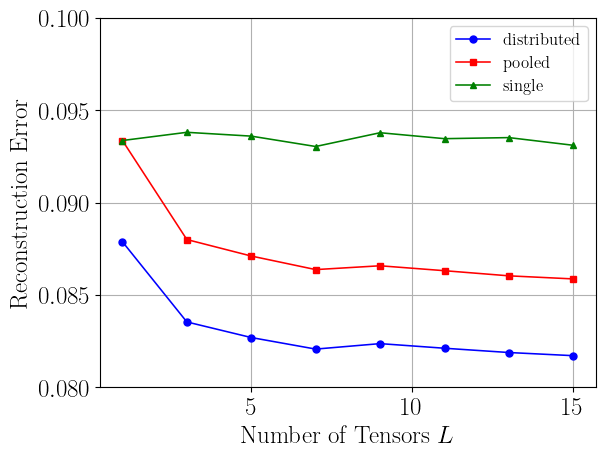

In [8]:
# Plot the results
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 18})

res = res_estimated_r
ms = 5
lw = 1.15
L_seq = np.arange(1, 16, 2)
start = 0
plt.plot(L_seq[start:], res[start:, 0], linewidth=lw, marker='o', linestyle='-', markersize=ms, label="distributed", color="blue")
plt.plot(L_seq[start:], res[start:, 2], linewidth=lw, marker='s', linestyle='-', markersize=ms, label="pooled", color="red")
plt.plot(L_seq[start:], res[start:, 1], linewidth=lw, marker='^', linestyle='-', markersize=ms, label="single", color="green")

plt.legend(loc='upper right', fontsize=12)
plt.xlabel("Number of Tensors $L$")
plt.ylabel("Reconstruction Error")
plt.ylim(0.08, 0.1)
plt.grid(True)
#plt.yscale("log")
#plt.savefig(f"PTC_FM.png", bbox_inches='tight', dpi=150)
plt.show()